In [1]:
import pandas as pd
from packages.functions import *

In [2]:
df = pd.read_csv("well_35_9-5.csv")

In [3]:
# Take a copy for comparison of filtered with unfiltered
filt = df.copy()
filt = filt.rolling(11).median()

# Normalise for outlier removal

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

# scaler = PowerTransformer(method='yeo-johnson')

# ct = ColumnTransformer([('transform', scaler, input_columns)], remainder='passthrough')

# filt.dropna(inplace=True)
# trans = ct.fit_transform(filt)

# trans = pd.DataFrame(trans, columns=input_columns)

# Remove Outliers prior to feature engineering

In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# fig, ax = plt.subplots()
# ax.boxplot(trans)
# plt.show()

# Create velocity, impedance and porosity logs

In [6]:
df = rplog_convert(df, "DTC", "DTS")
df['PHIE'] = density_porosity(df.RHOB, 2.8, 1.1)
# Repeat for median filtered version
filt = rplog_convert(filt, "DTC", "DTS")
filt['PHIE'] = density_porosity(filt.RHOB, 2.8, 1.1)

# Calculate Shale logs from GR log

In [7]:
# Calculates a number of VSH versions
df = vshale_from_gr(df)
filt = vshale_from_gr(filt)

# Calculate Water Saturation
## Archies Equation

$$S_w =\Bigg( \frac{aR_w}{R_t \phi^m}\Bigg)^\frac{1}{n}$$
    
$S_w$ : water saturation of the uninvaded zone \
`n`  : saturation exponent, 1.8-4.0, usually 2.0 \
$R_w$ : formation water resistivity at formation temperature \
$\phi$: porosity \
`m`  : cementation exponent, 1.7-3.0, usually 2.0 \
$R_t$ : true resistivity of the formation, corrected for invasion \
`a`  : 1 (carbonate), 0.62 (sandstone) \

In [8]:
# Archies Equation: 
n = 2
rw = df.RSHA # RXO
phi = df.PHIE
m = 2
rt = df.RDEP # RMED
a = 0.62

# Sw = ((a * rw) / (rt * phi^m))**0.5

In [9]:
input_columns = ['GR', 'DTC', 'DTS', 'RHOB', 'NPHI', 'RSHA', 'RDEP']
rock_physics_curves = ['GR', 'VSH', 'VP', 'VS', 'RHOB', 'NPHI', 'IP', 'IS', 'VPVS', 'PHIE'] #'SW'

In [10]:
# Remove DT, DTS, VSH_{versions}, IGR. Replaced with VP, VS
df = df[rock_physics_curves]
filt = filt[rock_physics_curves]

# Plot basic rock physics logs and compare unfiltered with filtered

(4941.0, 0.0)

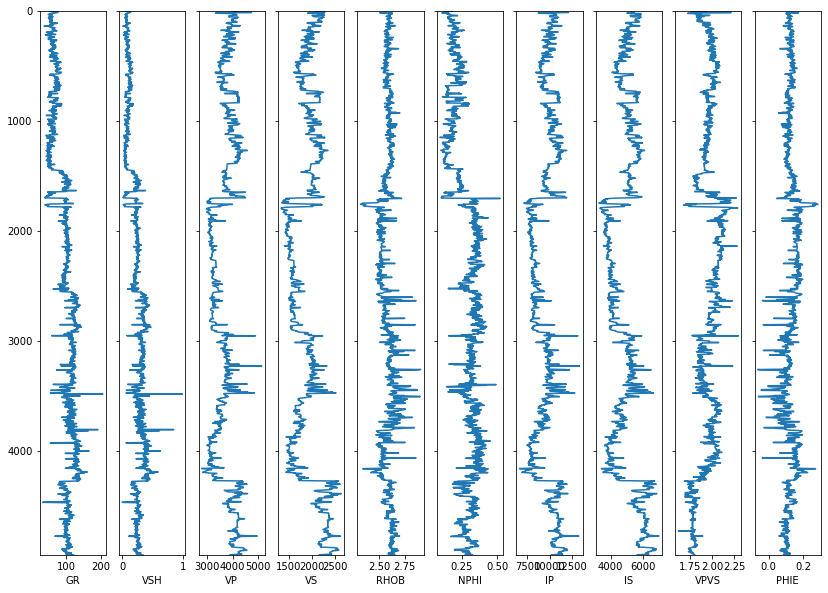

In [11]:
# Plot logs from unfiltered
fig, axs = plt.subplots(1, len(df.columns), figsize=(14, 10), sharey=True)
for ic, col in enumerate(df.columns):
    axs[ic].plot(df[col], df.index)
    axs[ic].set_xlabel(col)
axs[0].set_ylim(df.index.values[-1], df.index.values[0])

(4941.0, 0.0)

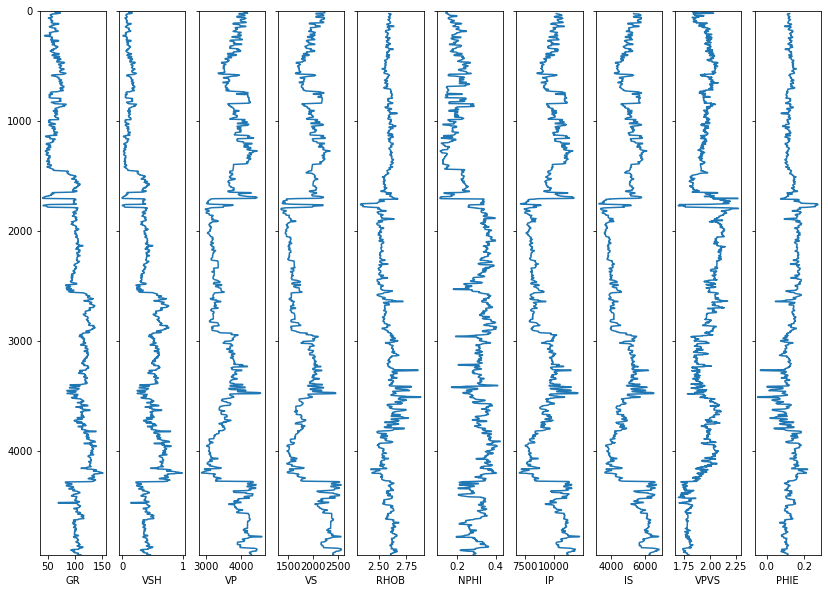

In [12]:
# Plot logs from filtered
fig, axs = plt.subplots(1, len(filt.columns), figsize=(14, 10), sharey=True)
for ic, col in enumerate(filt.columns):
    axs[ic].plot(filt[col], filt.index)
    axs[ic].set_xlabel(col)
axs[0].set_ylim(filt.index.values[-1], filt.index.values[0])

In [13]:
# Plot these, histogram and boxplots ???
filt_unfilt_diff(df, filt)

LOG:		Unfiltered	:	Filtered
GR min: 	32.97 		: 	40.83
GR max: 	205.34 		: 	150.77
------------------------------------------------
VSH min: 	0.00 		: 	0.00
VSH max: 	0.99 		: 	0.99
------------------------------------------------
PHIE min: 	-0.06 		: 	-0.05
PHIE max: 	0.28 		: 	0.27
------------------------------------------------
IP min: 	6590.18 	: 	7000.80
IP max: 	13352.14 	: 	12201.26
------------------------------------------------
VPVS min: 	1.62 		: 	1.69
VPVS max: 	2.30 		: 	2.28
------------------------------------------------
VP min: 	2776.12 	: 	2868.87
VP max: 	5139.84 	: 	4580.55
------------------------------------------------
VS min: 	1338.06 	: 	1352.56
VS max: 	2635.74 	: 	2556.11
------------------------------------------------
RHOB min: 	2.32 		: 	2.33
RHOB max: 	2.91 		: 	2.88


# Calculate lithofacies (litho-fluid-facies)
ref: https://github.com/seg/tutorials-2015/blob/master/1504_Seismic_petrophysics_1/Seismic_petrophysics_1.ipynb

In [14]:
# ztop = 3300; zbot = df.DEPTH_MD.max()

# logs = df.loc[(df.DEPTH_MD>=ztop) & (df.DEPTH_MD<=zbot)]

# sand_cutoff = 0.20
# brine_sand = ((logs.VSH <= sand_cutoff) & (logs.SW >= 0.9))
# oil_sand = ((logs.VSH <= sand_cutoff) & (logs.SW < 0.9))
# shale = (logs.VSH > sand_cutoff)

# temp_lfc = np.zeros(np.shape(logs.VSH))
# temp_lfc[brine_sand.values] = 1    # LFC will be 1 when ssb (brine sand flag) is True
# temp_lfc[oil_sand.values] = 2      # LFC will be 2 when sso (oil sand flag) is True
# temp_lfc[shale.values] = 4         # LFC will be 4 when sh (shale flag) is True
# logs['LFC'] = temp_lfc             # Copy the temporary log temp_lfc into the DataFrame with name `LFC`

# # logs.to_csv('qsiwell2_lfc.csv',index=False) # save the data for use in Part 2

# Plot unfiltered and filtered logs

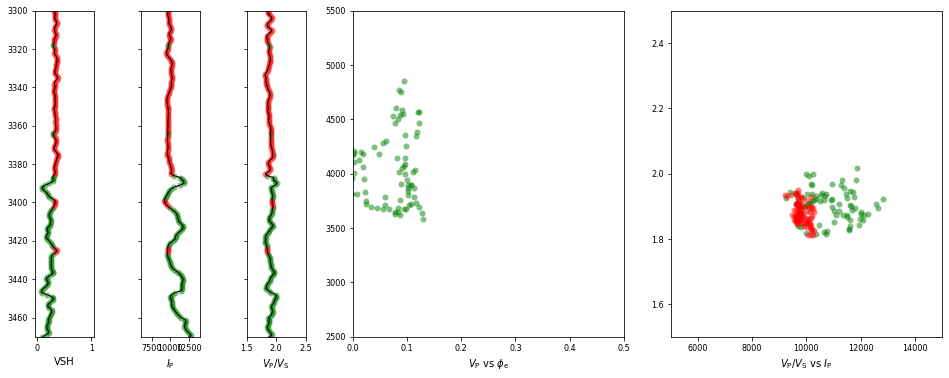

In [15]:
# Unfiltered
plotlog(df, 3300, 3470, 0.3, 0.3)

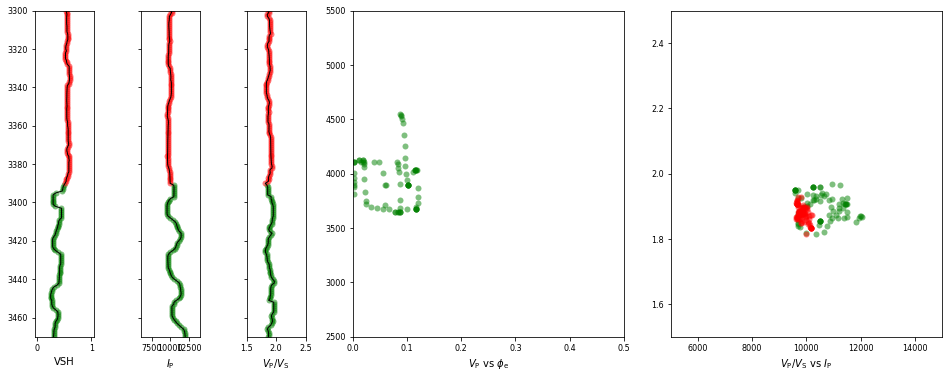

In [16]:
# Filtered
plotlog(filt, 3300, 3470, 0.5, 0.5)

In [17]:
df.head()

,GR,VSH,VP,VS,RHOB,NPHI,IP,IS,VPVS,PHIE
0,52.358788,0.055695,3992.538899,2080.185981,NaN,0.182736,NaN,NaN,1.919318,NaN
1,53.945919,0.060650,4083.522013,2116.760200,NaN,0.173941,NaN,NaN,1.929138,NaN
2,57.660477,0.072497,4150.927354,2166.828327,NaN,0.170743,NaN,NaN,1.915670,NaN
3,60.773514,0.082701,4161.170597,2206.662461,NaN,0.162377,NaN,NaN,1.885730,NaN
4,62.899895,0.089820,4101.605982,2225.891984,NaN,0.155323,NaN,NaN,1.842680,NaN


In [18]:
df.to_csv("rp_35_9-5.csv")